# 0. Import Dependencies

In [1]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp
import tensorflow as tf
import math

from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, classification_report
from tensorflow.keras.utils import to_categorical

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.layers import (LSTM, Dense, Concatenate, Attention, Dropout, Softmax,
                                     Input, Flatten, Activation, Bidirectional, Permute, multiply, 
                                     ConvLSTM2D, MaxPooling3D, TimeDistributed, Conv2D, MaxPooling2D)

from scipy import stats

# disable some of the tf/keras training warnings 
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "3"
tf.get_logger().setLevel("ERROR")
tf.autograph.set_verbosity(1)

# suppress untraced functions warning
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

2024-03-08 16:05:34.540384: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-08 16:05:34.540416: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-08 16:05:34.542747: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-08 16:05:34.740415: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# 3. Setup Folders for Collection

In [3]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join(os. getcwd(),'../Data_Round1/Test_R1') 
print(DATA_PATH)

# Actions/exercises that we try to detect
actions = np.array(['chest fly machine', 'deadlift', 'hammer curl',
                    'incline bench press', 'pull Up', 'tricep dips', 
                    'decline bench press', 'leg raises', 'shoulder press',
                    'plank', 'leg extension', 'tricep Pushdown',
                    'bench press', 'lateral raise', 'squat',
                    'push-up', 'barbell biceps curl', 'russian twist',
                    'romanian deadlift', 'hip thrust', 'lat pulldown',
                    't bar row'
                    ])

# Videos are going to be this many frames in length
sequence_length = 60

/media/volcano/SPSSD/DATA1/DUT/AI4LIFE/Exercise_Recognition_AI/../Data_Round1/Test_R1


# 4. Collect Keypoint Values for Training and Testing

In [4]:
import json

In [5]:
data_poses = {}
min_d = 1000
for action in actions:
    data_poses[action] = {}
    for filename in os.listdir(DATA_PATH+"/"+action+"/pose"):
        if filename.endswith('.json'):
            file_path = os.path.join(DATA_PATH+"/"+action+"/pose", filename)
            key_file = filename.replace('.json', '').replace('results_', '')
            # Open the JSON file and load its contents
            with open(file_path, 'r') as json_file:
                data = json.load(json_file)
            if len(data['instance_info']) >= sequence_length:
                # Do something with the data (for example, print it)
                data_poses[action][key_file] = []
                for frame in range(len(data['instance_info'])):
                    data_poses[action][key_file].append(data['instance_info'][frame]['instances'][0]['keypoints'])
                # if min_d > len(data['instance_info']):
                #     min_d = len(data['instance_info'])
                #     print(len(data['instance_info']))

# 5. Preprocess Data and Create Labels/Features

In [6]:
label_map = {label:num for num, label in enumerate(actions)}

In [7]:
label_map

{'chest fly machine': 0,
 'deadlift': 1,
 'hammer curl': 2,
 'incline bench press': 3,
 'pull Up': 4,
 'tricep dips': 5,
 'decline bench press': 6,
 'leg raises': 7,
 'shoulder press': 8,
 'plank': 9,
 'leg extension': 10,
 'tricep Pushdown': 11,
 'bench press': 12,
 'lateral raise': 13,
 'squat': 14,
 'push-up': 15,
 'barbell biceps curl': 16,
 'russian twist': 17,
 'romanian deadlift': 18,
 'hip thrust': 19,
 'lat pulldown': 20,
 't bar row': 21}

In [8]:
# Load and organize recorded training data
sequences, labels = [], []
for action in actions:
    for sequence in list(data_poses[action].keys()):
        mod_d = len(data_poses[action][sequence])//sequence_length
        for m in range(mod_d):
            window = []
            for frame_num in range(m*sequence_length, (m+1)*sequence_length):         
                # LSTM input data
                res = np.asarray(data_poses[action][sequence][frame_num]).flatten()
                window.append(res)  
                
            sequences.append(window)
            labels.append(label_map[action])

In [9]:
# Make sure first dimensions of arrays match
X = np.array(sequences)
y = to_categorical(labels).astype(int)
print(X.shape, y.shape)

(349, 60, 51) (349, 22)


# 6. Build and Train Neural Networks

In [10]:
# Callbacks to be used during neural network training 
es_callback = EarlyStopping(monitor='val_loss', min_delta=5e-4, patience=10, verbose=0, mode='min')
lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=0, mode='min')
chkpt_callback = ModelCheckpoint(filepath=DATA_PATH, monitor='val_loss', verbose=0, save_best_only=True, 
                                 save_weights_only=False, mode='min', save_freq=1)

# Optimizer
# opt = tf.keras.optimizers.Adam(learning_rate=0.01)
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.01)

# some hyperparamters
batch_size = 32
max_epochs = 500

## 6b. LSTM + Attention

In [11]:
# Set up Tensorboard logging and callbacks
NAME = f"ExerciseRecognition-AttnLSTM-{int(time.time())}"
log_dir = os.path.join(os.getcwd(), 'logs', NAME,'')
tb_callback = TensorBoard(log_dir=log_dir)

callbacks = [tb_callback, es_callback, lr_callback, chkpt_callback]

In [12]:
def attention_block(inputs, time_steps):
    """
    Attention layer for deep neural network
    
    """
    # Attention weights
    a = Permute((2, 1))(inputs)
    a = Dense(time_steps, activation='softmax')(a)
    
    # Attention vector
    a_probs = Permute((2, 1), name='attention_vec')(a)
    
    # Luong's multiplicative score
    output_attention_mul = multiply([inputs, a_probs], name='attention_mul') 
    
    return output_attention_mul

In [13]:
HIDDEN_UNITS = 256

# Input
inputs = Input(shape=(sequence_length, 51))

# Bi-LSTM
lstm_out = Bidirectional(LSTM(HIDDEN_UNITS, return_sequences=True))(inputs)

# Attention
attention_mul = attention_block(lstm_out, sequence_length)
attention_mul = Flatten()(attention_mul)

# Fully Connected Layer
x = Dense(2*HIDDEN_UNITS, activation='relu')(attention_mul)
x = Dropout(0.5)(x)

# Output
x = Dense(actions.shape[0], activation='softmax')(x)

# Bring it all together
AttnLSTM = Model(inputs=[inputs], outputs=x)

2024-03-08 16:06:18.211817: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-08 16:06:18.266370: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-08 16:06:18.266538: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
AttnLSTM.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
# AttnLSTM.fit(X_train, y_train, batch_size=batch_size, epochs=max_epochs, validation_data=(X_val, y_val), callbacks=callbacks)

In [15]:
# Model map
models = {
    # 'LSTM': lstm, 
    'LSTM_Attention_128HUs': AttnLSTM, 
}

# 7b. Load Weights

In [16]:
# Run model rebuild before doing this
for model_name, model in models.items():
    load_dir = os.path.join(os.getcwd(), f"{model_name}_f1.h5")
    model.load_weights(load_dir)

# 8. Make Predictions

In [17]:
for model in models.values():
    res = model.predict(X, verbose=0)   

2024-03-08 16:06:28.438218: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


# 9. Evaluations using Confusion Matrix and Accuracy

In [18]:
eval_results = {}
eval_results['confusion matrix'] = None
eval_results['accuracy'] = None
eval_results['precision'] = None
eval_results['recall'] = None
eval_results['f1 score'] = None

confusion_matrices = {}
classification_accuracies = {}   
precisions = {}
recalls = {}
f1_scores = {} 

## 9a. Confusion Matrices

In [19]:
for model_name, model in models.items():
    yhat = model.predict(X, verbose=0)
    # Get list of classification predictions
    ytrue = np.argmax(y, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Confusion matrix
    confusion_matrices[model_name] = multilabel_confusion_matrix(ytrue, yhat)
    # print(f"{model_name} confusion matrix: {os.linesep}{confusion_matrices[model_name]}")

# Collect results 
eval_results['confusion matrix'] = confusion_matrices

In [20]:
corr_matrix_k = np.zeros((len(actions), len(actions)))
corr_matrix = np.zeros((len(actions), len(actions)))
for t in range(len(yhat)):
    corr_matrix_k[ytrue[t]][yhat[t]] += 1
for t in range(len(actions)):
    for k in range(len(actions)):
        corr_matrix[t][k] = corr_matrix_k[t][k]/np.sum(corr_matrix_k[t])

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

## 9b. Accuracy

In [22]:
for model_name, model in models.items():
    yhat = model.predict(X, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Model accuracy
    classification_accuracies[model_name] = accuracy_score(ytrue, yhat)    
    print(f"{model_name} classification accuracy = {round(classification_accuracies[model_name]*100,3)}%")

# Collect results 
eval_results['accuracy'] = classification_accuracies

LSTM_Attention_128HUs classification accuracy = 29.799%


## 9c. Precision, Recall, and F1 Score

In [23]:
for model_name, model in models.items():
    yhat = model.predict(X, verbose=0)
    
    # Get list of classification predictions
    ytrue = np.argmax(y, axis=1).tolist()
    yhat = np.argmax(yhat, axis=1).tolist()
    
    # Precision, recall, and f1 score
    report = classification_report(ytrue, yhat, target_names=actions, output_dict=True)
    
    precisions[model_name] = report['weighted avg']['precision']
    recalls[model_name] = report['weighted avg']['recall']
    f1_scores[model_name] = report['weighted avg']['f1-score'] 
   
    print(f"{model_name} weighted average precision = {round(precisions[model_name],3)}")
    print(f"{model_name} weighted average recall = {round(recalls[model_name],3)}")
    print(f"{model_name} weighted average f1-score = {round(f1_scores[model_name],3)}\n")

# Collect results 
eval_results['precision'] = precisions
eval_results['recall'] = recalls
eval_results['f1 score'] = f1_scores

LSTM_Attention_128HUs weighted average precision = 0.496
LSTM_Attention_128HUs weighted average recall = 0.298
LSTM_Attention_128HUs weighted average f1-score = 0.304



/home/volcano/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volcano/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/volcano/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


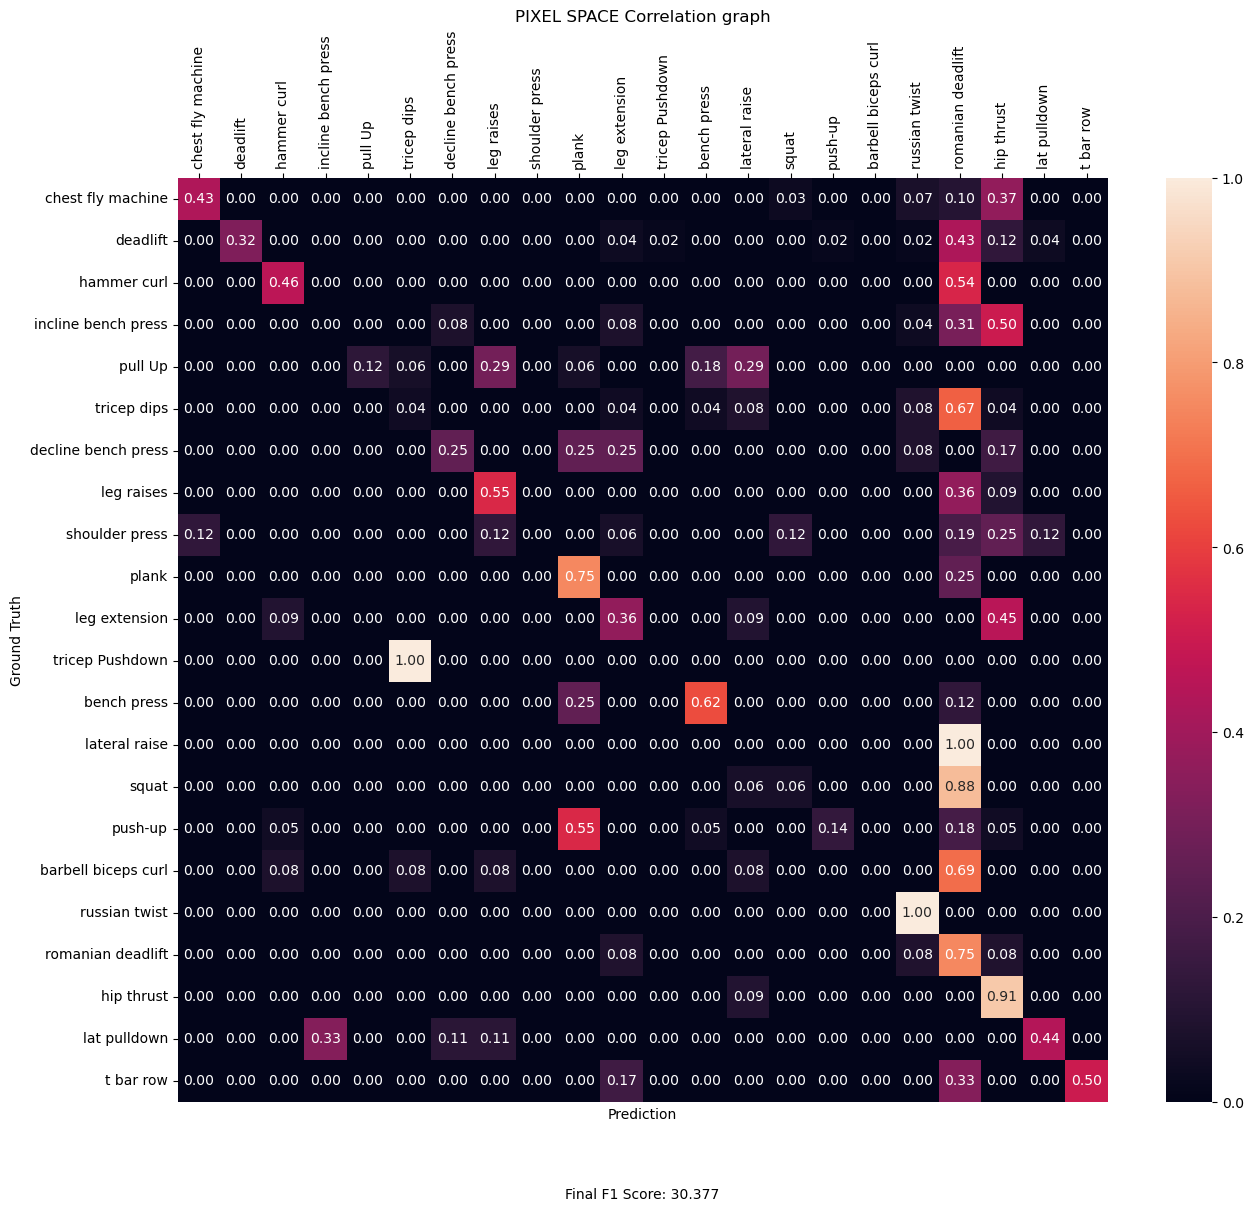

In [24]:
plt.figure(figsize=(15, 12))
ax = sns.heatmap(corr_matrix, annot=True, fmt=".2f",
            xticklabels=actions, yticklabels=actions)
ax.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)
plt.xticks(rotation=90)
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.title('PIXEL SPACE Correlation graph')
plt.text(0.5, -0.1, f"Final F1 Score: {f1_scores['LSTM_Attention_128HUs']*100:.3f}", horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
plt.savefig(f'PIXCEL_SPACE_CORR_F1_RESULT-{int(time.time())}.png')